In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
100% 787M/787M [00:15<00:00, 65.4MB/s]
100% 787M/787M [00:15<00:00, 53.8MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/kaggle-cat-vs-dog-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

In [5]:
!ls

kagglecatsanddogs_3367a  kaggle-cat-vs-dog-dataset.zip	kaggle.json  sample_data


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from PIL import Image

In [7]:
cat = os.listdir('/content/kagglecatsanddogs_3367a/PetImages/Cat')
cats = cat[0:500]

In [8]:
dog = os.listdir('/content/kagglecatsanddogs_3367a/PetImages/Dog')
dogs = dog[0:500]

In [9]:
len(cats)

500

In [10]:
len(dogs)

500

Creating labels for the 2 classes


cat - 0





dog - 1

In [11]:
cat_label = [0]*500
dog_label = [1]*500

In [12]:
labels = cat_label + dog_label

In [13]:
labels[0:5]


[0, 0, 0, 0, 0]

In [14]:
labels[-5:]

[1, 1, 1, 1, 1]

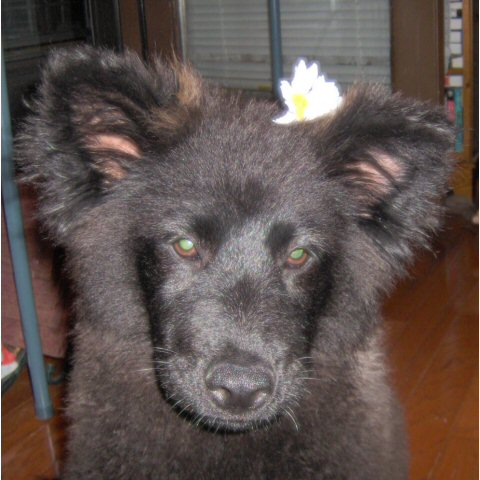

In [15]:
#displaying the images
img = cv2.imread('/content/kagglecatsanddogs_3367a/PetImages/Dog/10200.jpg')
display = cv2_imshow(img)

In [16]:
#image processing
cat_path = '/content/kagglecatsanddogs_3367a/PetImages/Cat/'

data = []

for img_path in cats:
  image = Image.open(cat_path + img_path)
  image = image.resize((224,224))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

  #image processing
dog_path = '/content/kagglecatsanddogs_3367a/PetImages/Dog/'

for img_path in dogs:
  image = Image.open(dog_path + img_path)
  image = image.resize((224,224))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

In [17]:
len(data)

1000

In [18]:
type(data[0])

numpy.ndarray

In [19]:
data[0].shape

(224, 224, 3)

In [20]:
x = np.array(data)
y = np.array(labels)

In [21]:
y.shape

(1000,)

In [22]:
x.shape

(1000, 224, 224, 3)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [24]:
#scaling of data
x_train = x_train/255
x_test = x_test/255

In [25]:
#building the neural network
import tensorflow as tf
import tensorflow_hub as hub

In [26]:
mobilenet_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"


In [27]:
pretrained = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3),trainable= False)

In [28]:
classes = 2

model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.Dense(classes)
])


In [29]:
model.compile(
    optimizer= 'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy']
)

In [30]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
25/25 [==============================] - 10s 41ms/step - loss: 0.8202 - accuracy: 0.8600
Epoch 2/10
25/25 [==============================] - 1s 39ms/step - loss: 0.1496 - accuracy: 0.9750
Epoch 3/10
25/25 [==============================] - 1s 38ms/step - loss: 0.1046 - accuracy: 0.9850
Epoch 4/10
25/25 [==============================] - 1s 39ms/step - loss: 0.1082 - accuracy: 0.9812
Epoch 5/10
25/25 [==============================] - 1s 39ms/step - loss: 0.1063 - accuracy: 0.9837
Epoch 6/10
25/25 [==============================] - 1s 39ms/step - loss: 0.0918 - accuracy: 0.9900
Epoch 7/10
25/25 [==============================] - 1s 39ms/step - loss: 0.1050 - accuracy: 0.9887
Epoch 8/10
25/25 [==============================] - 1s 38ms/step - loss: 0.1007 - accuracy: 0.9862
Epoch 9/10
25/25 [==============================] - 1s 39ms/step - loss: 0.1006 - accuracy: 0.9862
Epoch 10/10
25/25 [==============================] - 1s 40ms/step - loss: 0.1014 - accuracy: 0.9862


In [31]:
score, acc = model.evaluate(x_test,y_test)

7/7 [==============================] - 2s 155ms/step - loss: 0.1792 - accuracy: 0.9700


In [32]:
X_train_features = model.predict(x_train)
X_test_features = model.predict(x_test)

7/7 [==============================] - 1s 34ms/step


In [33]:
X_train_features_1 = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_1 = X_test_features.reshape(X_test_features.shape[0], -1)

In [42]:
# Initialize the SVM classifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


svm_classifier = SVC(kernel='linear', probability=True)

# Train the classifier
svm_classifier.fit(X_train_features_1, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test_features_1)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.965


In [43]:
# Function to classify a new image
def classify_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224,224))
    img = img.convert('RGB')
    img = np.array(img)
    img = img/255.0
    img = img.reshape(1, 224, 224, 3)
    features = model.predict(img)
    features = features.reshape(1, -1)
    prediction = svm_classifier.predict(features)
    return 'Dog' if prediction == 1 else 'Cat'

# Example usage
print(classify_image('/content/kagglecatsanddogs_3367a/PetImages/Cat/10047.jpg'))




1/1 [==============================] - 0s 22ms/step
Cat
